In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

In [2]:
# size of training data set
training_size = 100
# dimension of data sets
n = 2
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
# load iris and normalise
x = preprocessing.normalize(iris.data)
x1_train = x[0:49, :] # class A
x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [3]:
sv = Statevector.from_label('0' * n)

In [4]:
def final_circuit(circuit, data, params):
    angle_y = ((np.pi-data[0])*(np.pi-data[1]))
    angle_z = ((np.pi-data[2])*(np.pi-data[3]))
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i],i)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i+2],i)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i+4],i)

In [5]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 2  # num of trainable params
for i in range(100):
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,6)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,6)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Layer3Hard/quantum_loss_hard_layer3_%d.npy' %i
    f2 = 'Layer3Hard/opt_params_hard_layer3_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823]
[0.7830763125737311, 0.6534343560284009, 0.5693984980630646, 0.5091364002299634, 0.4634434900869173, 0.4271986356430809, 0.3955899085754996, 0.36606593138976296, 0.33862280740649714, 0.3140596944377121, 0.29305086637238303, 0.27578597673539373, 0.26172604676665123, 0.24967463578682042, 0.2384296875377243, 0.2273539546822268, 0.21633302209103106, 0.20541662969895674, 0.19449044193790616, 0.18327915820615817, 0.17173795334123068, 0.16031958267558055, 0.14981095569894154, 0.1409936880185604, 0.1343661380077704, 0.130023147278301, 0.1277311509010051, 0.12709170240669018, 0.12761872790128975, 0.12873157731348922, 0.129791540824749, 0.13023379440256566, 0.12973111663874456, 0.12827935978350619, 0.12614068886275925, 0.12368410911110275, 0.12122277483810548, 0.11892894426832853, 0.11684711668003298, 0.11496235360223436, 0.1132555367263524, 0.1117125178790179, 0.11030970814845228, 0.10901673580560847, 0.10782428086185772,

[1.8717979922688066, 1.6768975428412565, 1.4877129632006745, 1.3150689031426424, 1.1627451410167584, 1.0307024598242929, 0.9180478499747025, 0.8251612422476176, 0.7535063868703322, 0.704269438599211, 0.6768918249831724, 0.668126950800222, 0.6721904253929282, 0.6821980251352068, 0.6920811054334887, 0.6977519920591697, 0.6972317918367287, 0.6902562927027082, 0.6777728389814301, 0.6614401532492298, 0.6431508617298723, 0.6246116382120696, 0.6070267135197361, 0.5909204553269901, 0.5761175765452339, 0.561879254125548, 0.5471628410247047, 0.5309375896465529, 0.5124690802218321, 0.4914990392696382, 0.4682906715776763, 0.4435536501597907, 0.4182852216526352, 0.39356972620796704, 0.3703774590524098, 0.3494009309667469, 0.3309584890931262, 0.3149806375611453, 0.30107444433376684, 0.28864194832432355, 0.2770173933775177, 0.2655912182502086, 0.25390372682397744, 0.24170616776961326, 0.2289913234923256, 0.21599080402735624, 0.20313073592149497, 0.19094142360583227, 0.1799312381203425, 0.170453771144

[1.4069910869454392, 1.163152738435128, 0.9827411769523462, 0.8442170823111304, 0.7332827343815181, 0.6410607140353397, 0.5651400729728111, 0.5053049011791753, 0.4597317565147212, 0.42419223513036025, 0.3931026690091383, 0.36146320600198345, 0.32659612605969324, 0.2887262427246261, 0.25032526072102096, 0.2148792417041696, 0.185725697511558, 0.16524015803602243, 0.15439115471672737, 0.15261338666185836, 0.15796846508684378, 0.16757123337185229, 0.1782118504460274, 0.1870255145927377, 0.19202479277416862, 0.1923616042825068, 0.1882957735715288, 0.18094066692257474, 0.17189200787386463, 0.16283603019873297, 0.15520605562285755, 0.149933426515826, 0.1473224472387491, 0.14706310708213405, 0.14837415571585527, 0.15024073362262758, 0.15168420030068022, 0.15199178017652235, 0.15084937621673677, 0.1483560769833713, 0.14493627385598384, 0.14118973166993756, 0.13772643707457688, 0.1350262956096373, 0.13335010932728422, 0.13271304763385938, 0.13291742998572192, 0.13362951603633091, 0.1344768710008

[0.7372293154937987, 0.5847664508783169, 0.4713391966047138, 0.3913683160988479, 0.3360090439347129, 0.29634891990388607, 0.2656724091058624, 0.2401310729206887, 0.218085428126719, 0.19896767366606788, 0.18239817633221683, 0.16786249460779185, 0.15481629617899856, 0.1428950473672835, 0.13203457849942954, 0.12247352605340175, 0.1146546250638327, 0.10905528949650856, 0.10599665826992628, 0.10548845544955295, 0.10716036208762376, 0.110312287519691, 0.11407874913466624, 0.11764848594085214, 0.12044556640018443, 0.12220070263919844, 0.12290791892617718, 0.12271620370494014, 0.12181757825551999, 0.12037507277035853, 0.11850633055196075, 0.11631129258094404, 0.11391353863923469, 0.11148251860670487, 0.10921949002687982, 0.1073123120843957, 0.10588157046892453, 0.10494545991331398, 0.1044225273538674, 0.10417264013629181, 0.10405599357909527, 0.10398022156061584, 0.10391436202292414, 0.10386938569775604, 0.10386357772666689, 0.10389596616603106, 0.1039412018046597, 0.10396377693630104, 0.10393

[1.03996154566161, 0.8687510856150367, 0.7062923907084587, 0.5587543173885108, 0.434552595445461, 0.34003259705606326, 0.27635836045480516, 0.23830376418376142, 0.21997707616883302, 0.21571354834140885, 0.21936121159080477, 0.22503807444417784, 0.2281686623468692, 0.2260544480244613, 0.21786069888910845, 0.20424362985636485, 0.1868429015542926, 0.16775753733952298, 0.14907575678318274, 0.13251196997295112, 0.11918077929032109, 0.10951266764784158, 0.1032997295750982, 0.09984808203709991, 0.0981994149981367, 0.09736980402620511, 0.09654999550821464, 0.09522512521863902, 0.09319954539804791, 0.09054128695762981, 0.08747884630739437, 0.084287279333311, 0.08119416307458717, 0.07832462220665551, 0.07569158234513884, 0.07322464092982461, 0.07082071639804804, 0.06839531461937155, 0.06591650488563346, 0.06341334320293691, 0.060961439818834, 0.058655750271469416, 0.05658245000275369, 0.05479885571653093, 0.05332559344885689, 0.052150501314164426, 0.05124025524295447, 0.05055392903119341, 0.0500

[0.45113855828450455, 0.36172282890417506, 0.2961142578638151, 0.2522114167840159, 0.22936498955055712, 0.22564762554694615, 0.2350612752192035, 0.2478925843676696, 0.25668730270255813, 0.2590192007176599, 0.25528720981504016, 0.24677118667837658, 0.2348589438969596, 0.2209198560706643, 0.20635501142724627, 0.19254712383746203, 0.1807021086003903, 0.17169817132477339, 0.1659922065477049, 0.16356000326887624, 0.1638642724824375, 0.16590508862485803, 0.16840854596079782, 0.17013290545124493, 0.17019545075547393, 0.16828973106268766, 0.16470263733193666, 0.1601487637212246, 0.15551346394273316, 0.1515910361346823, 0.14887497391191712, 0.14744218771492237, 0.14696344824475746, 0.1468434792160454, 0.14644165963728417, 0.14528174204143274, 0.14316744068477194, 0.1401771436793815, 0.136568283709294, 0.1326474734587429, 0.12865686525535436, 0.12470858729815094, 0.12077789690121056, 0.11674666769338589, 0.11247456015445711, 0.10786917498963959, 0.10293156918385866, 0.09776625512115827, 0.092558

[1.0141902689735283, 0.79959656322209, 0.6927581947839319, 0.6463876758871069, 0.6239938350951931, 0.6026880565674935, 0.5736652874508499, 0.5368271366372661, 0.4952487909940067, 0.45228703189187835, 0.41061005379958304, 0.3720671355501139, 0.3378262603820495, 0.3085576172641051, 0.284585872377875, 0.2659845580516017, 0.25260875232885205, 0.24408069032989738, 0.23975809768013318, 0.23872138372415047, 0.23981032110598677, 0.24172344142551755, 0.24317000295732033, 0.24304331991479805, 0.24057353644423332, 0.23542180022448045, 0.22769493636097518, 0.21788180807081106, 0.20673135088215738, 0.19510262668579123, 0.18381841267525276, 0.17354769177202437, 0.16473271736102849, 0.15756550864655217, 0.1520086819046372, 0.14784825387388595, 0.14476232512841017, 0.1423899631029045, 0.14038856086119658, 0.13847354202865517, 0.13643966623419823, 0.13416672760346654, 0.13161386738448025, 0.12880662850048513, 0.12581994073466699, 0.12275936276586669, 0.11974222544717998, 0.11688015164393895, 0.11426447

[1.443449698802409, 1.0247971338833, 0.7326316529888005, 0.5314015339960395, 0.39496880989561683, 0.30531709251690337, 0.24960374557137882, 0.21840592133040154, 0.2046552275607085, 0.20293657363386733, 0.20902278035727734, 0.21957942407016054, 0.23198768912980358, 0.24424073609995708, 0.25487976292526493, 0.2629460486980045, 0.26793404338264976, 0.26973667364717513, 0.26857880030135955, 0.26493805247025887, 0.25945590091222576, 0.2528442788072967, 0.2457959095897265, 0.23890728073542142, 0.23262252272995335, 0.2272040775167604, 0.2227317998929844, 0.21912762362358396, 0.21619861747832514, 0.21368868255841955, 0.21132902125686603, 0.20887969420415542, 0.20615802914740902, 0.20305327584701874, 0.19952926037118185, 0.19561807497096717, 0.19140770910167176, 0.18702612379347366, 0.18262358627167244, 0.17835482965494442, 0.1743624128205238, 0.1707626207238788, 0.16763512016722426, 0.1650173199599452, 0.1629038599641277, 0.16125106084851146, 0.1599855238083684, 0.15901549953756489, 0.15824329

[ 0.71777853 -0.25457769  0.11025756  0.9113131   0.4733392   0.63241028]
[0.49511538998542, 0.34896535074710633, 0.2568019999857413, 0.2127221346834853, 0.20608067008345415, 0.22202755977684854, 0.24532980248983308, 0.2648932713236331, 0.2751716680502602, 0.2750889861742163, 0.26636067730563934, 0.25201016799280584, 0.23526723847430356, 0.2188653372451678, 0.20472730374498918, 0.193965162752577, 0.18701402059760566, 0.1837379118963588, 0.18349080664461892, 0.18521078550687314, 0.18760774890767135, 0.1894371481915808, 0.1897867927920836, 0.1882736653715391, 0.18507715616722492, 0.18080743356859336, 0.17627576633058825, 0.17225491330808693, 0.16929634799878363, 0.16763356643456684, 0.16717153092675857, 0.16754862146930102, 0.16825142586207975, 0.16875631507972796, 0.16866402039304593, 0.16779195028577, 0.16620017165312906, 0.16414763532214835, 0.1619968035281589, 0.1600978511874006, 0.15868617983638225, 0.15782152512278064, 0.15738539267746998, 0.15713701933246568, 0.15680807915299516, 

[1.001941263236646, 0.8034299823757494, 0.6461593504022858, 0.5243432343173345, 0.4332622008100686, 0.3680831504644616, 0.32315921998741315, 0.29199006175744013, 0.26807936617480327, 0.2462882333879115, 0.2237728379017132, 0.20003575714648086, 0.1762832828091682, 0.15449679927195803, 0.1365732277406716, 0.1237418935793928, 0.11630005606466161, 0.11361649323605495, 0.11433408256198953, 0.11670515703319094, 0.11898596018295605, 0.1198014913773021, 0.11839291346335193, 0.11469467564703445, 0.10924411238834418, 0.10297069967474831, 0.09692895288452544, 0.09203707397020383, 0.08887490561239621, 0.08758313824206442, 0.08788508858202788, 0.0892191707339606, 0.0909327276546021, 0.0924677908468225, 0.09348058812332734, 0.0938711731033581, 0.09373493517157687, 0.09326892502589437, 0.09267170394572315, 0.09207020652850927, 0.0914941361493425, 0.0908992713745948, 0.09022104145548589, 0.08942819180402703, 0.08855036490194355, 0.08767002830166529, 0.0868876562614009, 0.08627930990262336, 0.085865599

[0.9955849673939231, 0.7811040157410847, 0.6116365997218964, 0.4827971690052011, 0.3837371715373211, 0.30757911361439083, 0.24998534380951673, 0.20642042428641683, 0.17383337022846368, 0.1512442288642731, 0.13849402773778596, 0.1351679363567459, 0.13999133838147215, 0.15051588313622352, 0.16324311160541924, 0.17445156234513978, 0.18140493205487582, 0.18304448599504053, 0.17981086395759271, 0.17303235248623777, 0.16432459489082651, 0.1551380866572717, 0.14645289211550383, 0.13863911187461214, 0.13153772004857187, 0.12475515193299888, 0.11801271054486677, 0.11133751884559757, 0.10502327387852818, 0.09945414584075365, 0.09492270653664012, 0.09152221394634193, 0.08913487478017187, 0.0874986669922339, 0.08631407377655974, 0.08534571129181573, 0.084481720769444, 0.08373316969503405, 0.08318061948093093, 0.08289586898787658, 0.08287524277950524, 0.08301416317213531, 0.08313408895069514, 0.0830487997364287, 0.08263819709567925, 0.08189481646649147, 0.08092300500782713, 0.07989415641181752, 0.0

[0.7625002393170245, 0.5679986513520178, 0.4122498218429673, 0.2927365164054093, 0.20751376609786715, 0.1519625721499065, 0.11993317672161322, 0.10502131682569847, 0.10150449571158965, 0.10475235308969355, 0.11134783486165158, 0.1190255399889507, 0.12637073091980403, 0.1324249804260183, 0.13642989941804645, 0.13779690599225336, 0.13622991265553577, 0.13186351684318917, 0.1253026386336121, 0.1175185158171217, 0.10962841180016741, 0.1026316264721697, 0.09718156009017209, 0.09346037581326494, 0.09119660084428709, 0.0898187965743454, 0.08868086225778045, 0.08727035915410772, 0.0853357470387725, 0.08291083369086495, 0.08024702612880412, 0.07768531746497076, 0.07551459273173454, 0.07386952878405303, 0.07271079894145678, 0.07189271406856347, 0.07127124030055462, 0.07078137040095939, 0.07044264621589537, 0.0703054848930658, 0.07038256178676668, 0.07060731581711717, 0.0708400683887004, 0.07091655084851098, 0.0707135132562889, 0.070198910278759, 0.06944321093533004, 0.06858886905395599, 0.067794

[0.6574238962855995, 0.5440512352971374, 0.4315409422954842, 0.33464468205540765, 0.26105862425541926, 0.21177658764788587, 0.18236362341413062, 0.1651804099307776, 0.15340661907113917, 0.1435962854512011, 0.13506731075825842, 0.12835395613618591, 0.12404916117923588, 0.1221736064039625, 0.12197445837670054, 0.12210241450484714, 0.12113162696272356, 0.11818824260000649, 0.11327524616965656, 0.10709735587645841, 0.10057521851694769, 0.09437874674746163, 0.08870316810089238, 0.08333440663674482, 0.07790130543529789, 0.07214537262077625, 0.06607559401219189, 0.05997142834569026, 0.05427553992241405, 0.04944446078137644, 0.04581452158706367, 0.043518217352105815, 0.04246570649317176, 0.04238818936011603, 0.042923272206078084, 0.0437108928676128, 0.04446817602672413, 0.045024135927333175, 0.04531356669663373, 0.04534411077310783, 0.045155810510628516, 0.04478911956079108, 0.044269512782007595, 0.043608581294255704, 0.04281566229205795, 0.041911733831415686, 0.040938337419914234, 0.039957465

[0.07951607768350769, 0.07577936919187389, 0.08179783171151789, 0.08471910873992067, 0.08292023130181125, 0.07887718313240012, 0.07518652138977232, 0.07327474744796021, 0.07327249527086276, 0.07424060255161687, 0.0747513119820645, 0.0740489420365017, 0.07256068851586102, 0.07119546096307511, 0.07045060578051285, 0.07019614459695026, 0.07001706993740424, 0.0695970969076917, 0.06894465728317573, 0.06833202964224408, 0.06794939362823178, 0.06770406027233698, 0.06739835524330853, 0.06694264754543246, 0.06639220770109636, 0.06590929385964957, 0.06569455388904266, 0.06580882720998722, 0.06606007546107544, 0.06617992856418609, 0.06605555059490882, 0.06575475577540636, 0.06545986827344782, 0.06535417711028614, 0.06546273555405306, 0.06563510908256805, 0.06571369448835457, 0.06565572013347487, 0.065520507506239, 0.06541194200622853, 0.065394645922173, 0.06543424573596422, 0.06545775419228331, 0.06544113193495821, 0.06540156660430158, 0.06536537824185389, 0.06535391171379498, 0.0653602749797584,

[0.7889327626770885, 0.5869380871070272, 0.4299222578775166, 0.31327252010607454, 0.23134354529666926, 0.17844639291868564, 0.1491842726897384, 0.13843378818860416, 0.14131490067766994, 0.15316504527631444, 0.16956486215276453, 0.1865248284340887, 0.20082998328148965, 0.21036768706291442, 0.2142419775884048, 0.2126213281307494, 0.20641129593596547, 0.19688560338648312, 0.18537535698629842, 0.1730660048093524, 0.16091041577925336, 0.14963319986641377, 0.13977711688282649, 0.13174027219957152, 0.12577599781525914, 0.12196022640578273, 0.12015338857488149, 0.11998781712542886, 0.12090146741364159, 0.12222094319107875, 0.12327676222606641, 0.12351931529018677, 0.1226024525789984, 0.12041427790984126, 0.11705494798789358, 0.11277775441929078, 0.10791645624111308, 0.1028186073073897, 0.09779620726117824, 0.0930964839053548, 0.08889010924158616, 0.08527200986732587, 0.08227042925411862, 0.07986099739966857, 0.07798324990489103, 0.07655704710440846, 0.07549647326158872, 0.07471938513578687, 0.

[0.37109112252827975, 0.265958509607232, 0.20667172728110297, 0.18233095025815352, 0.17866264370756743, 0.18329201882760388, 0.1880740527223226, 0.1888826563314125, 0.18451854910815402, 0.17590196494715996, 0.1653492854019787, 0.15561362079662458, 0.1488059663086872, 0.14559139613055572, 0.1450567441917279, 0.14531789560567906, 0.14447885243824332, 0.1414039983812736, 0.13597852830106802, 0.12889196236548292, 0.12120060048928691, 0.11391275552728619, 0.10772860792807791, 0.10295951913577714, 0.09957623696710216, 0.09731255129301129, 0.09577628962923587, 0.09455114549220885, 0.09328244522275286, 0.09173875249193227, 0.08984536062934088, 0.08768853631564372, 0.08548662621774139, 0.08352630209118293, 0.08207541664034884, 0.08129757251706111, 0.08119766230059544, 0.08162035626940296, 0.08230600963773213, 0.08298331534469088, 0.08345746391296603, 0.0836542894389607, 0.08360722026957834, 0.08340467850179248, 0.08313057544472806, 0.0828261146344312, 0.08248516909749544, 0.08207731418250841, 0

[1.1182310165968343, 0.9137308739060693, 0.7379781005142396, 0.5906115510156732, 0.472267552285269, 0.3819304736663037, 0.31708642643374135, 0.27407275805698694, 0.24852725404971115, 0.2358711686135948, 0.23174226422396324, 0.23232843424451377, 0.23458285619850808, 0.23629931142567223, 0.23605748223611814, 0.23310252254948258, 0.2272208565243588, 0.21862683758622525, 0.20784768183048002, 0.1956007891855041, 0.18267214014715802, 0.1698097127742562, 0.1576424249097939, 0.14662952351965874, 0.1370408306656747, 0.1289645923552906, 0.12233691249935515, 0.11698423910462316, 0.11266951423492466, 0.10913377579999518, 0.10612788101275884, 0.1034328111382207, 0.10086982893483462, 0.09830348312966654, 0.09564045246840037, 0.09282658218603662, 0.0898432902165087, 0.08670373665746597, 0.08344856347288433, 0.08014089981910087, 0.07686032772434857, 0.07369564319675803, 0.07073652091832826, 0.06806440387699329, 0.06574335945167847, 0.06381195033281807, 0.062277372859853276, 0.061113160003786485, 0.060

[0.8193252849032746, 0.6435525309731326, 0.5127952655350968, 0.42408149031408016, 0.36889625991334213, 0.3348265868117092, 0.31054404542315867, 0.2895279439433129, 0.2695820174257197, 0.2507524615996814, 0.23372037029899154, 0.2189955667451321, 0.20666982568179854, 0.19647840102644187, 0.18799313537892434, 0.18081741907473362, 0.174699609689411, 0.16954536902236084, 0.1653629191764709, 0.1621908851388824, 0.1600417517925982, 0.15887066850497925, 0.15856498877365852, 0.15894671556636467, 0.15978291254090152, 0.16080256048589298, 0.16171945798469212, 0.1622602033304361, 0.1621948482135967, 0.1613659610841588, 0.1597104087947868, 0.15726712466341744, 0.15416647135783743, 0.15060103410173092, 0.14678391938533197, 0.14290529820238035, 0.13909942700389688, 0.1354311676088996, 0.13190410936231078, 0.1284839772538238, 0.12512575426368838, 0.12179371026863557, 0.11846943973429933, 0.11515011052551644, 0.11184315245628898, 0.10856317365112388, 0.10533336849298322, 0.10218935836031762, 0.09918101

[0.8211812580659024, 0.6990155112640276, 0.6204693558027679, 0.5660654223901321, 0.5163736164150473, 0.4601897019744764, 0.3965986757942744, 0.3302292613218988, 0.2670866206215454, 0.21248793792469445, 0.1700905843056714, 0.1413782978395386, 0.1254376480692636, 0.11917309556934184, 0.11824564689113362, 0.1185687471939587, 0.117462573763027, 0.11387054387134263, 0.10795377351452565, 0.10057551540779834, 0.09289110193947193, 0.08604702847337217, 0.08094698715740166, 0.07807304318117228, 0.07738666717638301, 0.0783424074087233, 0.0800219362676271, 0.0813600061193516, 0.08140840922286736, 0.07957095191063025, 0.07574259829660789, 0.07031078155176052, 0.06402566166257052, 0.05779018330742488, 0.05243699737124202, 0.04854927618197107, 0.046360999720197575, 0.04574911133070078, 0.04630804878572808, 0.04747853099456512, 0.04869182737139526, 0.04949223168918191, 0.04961292662537919, 0.048997152669518054, 0.04777060939725069, 0.04617958274206919, 0.04451291005293832, 0.04302632592230304, 0.04188

[1.0711925829586788, 0.8621065081014958, 0.7331123579866526, 0.6514888605132514, 0.5842846998264399, 0.5174935168372102, 0.4501187216795997, 0.3856332903871493, 0.32744061021271137, 0.2774818791504975, 0.23645373959894783, 0.204519276957762, 0.18163808751435975, 0.16730857095356072, 0.1602484805591396, 0.1584930782783352, 0.15989107677494463, 0.16264036231583445, 0.1655624987322713, 0.1680804859499624, 0.17003012323698893, 0.171440013380098, 0.17236087798754693, 0.1727781363205756, 0.17260465206263892, 0.17172180677131849, 0.17002914522331733, 0.16747833207638055, 0.1640894567248431, 0.15995665077396007, 0.1552456550180888, 0.1501790875156831, 0.14500444996529124, 0.13994607019554176, 0.13515193465343467, 0.13065428344180302, 0.12636346430148468, 0.12210397644373831, 0.11768312766137826, 0.11296647818021775, 0.1079314622788677, 0.10268184981047551, 0.09742315743209597, 0.09241117988596662, 0.08789103480562806, 0.0840432019979451, 0.08094957241923606, 0.0785864739624137, 0.0768441678401

[0.942339775620675, 0.7971188338431007, 0.6800578281400513, 0.5879382648485234, 0.5203202444981174, 0.4747229691939079, 0.4474042967453183, 0.434242864448648, 0.43134638375134177, 0.43537088891880016, 0.4435928601814779, 0.45382532835268957, 0.4642820980457377, 0.47346754887375864, 0.48014251392234925, 0.4833930851846184, 0.48277537355109384, 0.47843245584950744, 0.4710607738139956, 0.4616982188318618, 0.45142512152875275, 0.44110679271906034, 0.4312618191594687, 0.4220656130395765, 0.4134322995774874, 0.4051009389217567, 0.3966935681548692, 0.3877775731180375, 0.3779876919528112, 0.3672198676574074, 0.3558313300933793, 0.34471055871838685, 0.33506783851239225, 0.32789396389552433, 0.3232818184788769, 0.32012951855405225, 0.31671764268055175, 0.3118472957670491, 0.3055353527427433, 0.29879812505122505, 0.2928906637524589, 0.28854164858863207, 0.2855655935201431, 0.2830609729507123, 0.28008365458389506, 0.27629164685428814, 0.2720784996088238, 0.26818849579855697, 0.2651739844546629, 0.

[0.40756419679705364, 0.33973813726331414, 0.28308293250878297, 0.238919212073967, 0.2044250523672979, 0.1759758232310927, 0.15227975285054993, 0.13215931037913853, 0.1140952028597606, 0.09741449538320164, 0.08272020893535462, 0.07110970158947127, 0.06333167602499593, 0.05931969314614944, 0.058211541866804585, 0.05885263661669657, 0.0603792643226589, 0.062240203187470144, 0.06381563261173491, 0.06438545115354838, 0.06350687352677978, 0.06122372692054378, 0.05794021776667951, 0.05419199959777045, 0.050468164586054964, 0.04710876692199099, 0.04426721704621726, 0.041937730159668715, 0.040050710439630294, 0.03859319513030487, 0.03765982600671284, 0.037374942700784834, 0.03774167007213159, 0.038559774315382246, 0.03950559878177013, 0.040299432420173226, 0.040800223757525185, 0.04097763372595551, 0.0408443530532914, 0.04043504509040077, 0.03983302767829561, 0.03918125063468422, 0.038632894856827776, 0.038270834735532236, 0.03806909907239633, 0.03793444166437536, 0.0377898215202996, 0.0376260

[0.5437830963832538, 0.40776727235929144, 0.3135123382417775, 0.2602752533422094, 0.24282785188768607, 0.25128715684758585, 0.2726841553593794, 0.2944054539666865, 0.3076372116251868, 0.30864413951803515, 0.2979747318415965, 0.27884773161441573, 0.255596616010197, 0.23248938346811318, 0.21293339643679177, 0.19898917754763223, 0.19115150834850092, 0.18842079119093746, 0.18870288424315254, 0.18949227124908907, 0.18864230326141948, 0.1849433494980877, 0.17831607415373438, 0.16961835649370838, 0.1602136326984918, 0.15148666997460508, 0.14444759528729412, 0.13949958532432571, 0.13639894117073603, 0.13440435586388705, 0.13256626148232514, 0.13004984178411982, 0.1263701419239383, 0.12147348228868145, 0.1156765395909744, 0.10951622025421719, 0.10356913443012629, 0.0982924256409362, 0.09392671266712675, 0.09048316729616517, 0.08780774051433839, 0.0856858478376415, 0.08393838116124197, 0.08247251515421065, 0.08127804103639868, 0.08038535322739422, 0.07981354217567485, 0.07953501020305676, 0.0794

[0.23919065276295995, 0.19404384460494972, 0.1764381091763964, 0.16377567199950524, 0.15243638461700745, 0.1439020670086524, 0.13891845678453787, 0.13675013245533651, 0.13575484160382195, 0.13420213121479316, 0.13099568637422632, 0.1259978521725573, 0.11983234456480941, 0.11338235345179123, 0.10732433626008236, 0.10190947126532864, 0.09702317876064884, 0.09240994349003208, 0.0878898716109812, 0.083454094590465, 0.07924658749000299, 0.07550289072447952, 0.07249160441686793, 0.07045444308855613, 0.06952769048229607, 0.06965909594647839, 0.07057025750321076, 0.07181175871814405, 0.07290607553350667, 0.07350860621607933, 0.07349990987027094, 0.07296966606861878, 0.07212011847572998, 0.07115276474681378, 0.07019499894628334, 0.06929018261836314, 0.0684371135884679, 0.06764173229421955, 0.06694519430217212, 0.06641401545727427, 0.06610409841189288, 0.06602494038845728, 0.0661271656617865, 0.06632022865985088, 0.0665086620658244, 0.066626019661172, 0.06664985194338832, 0.06659421763574472, 0.

[0.7364172941630911, 0.6024677500523835, 0.4976647471040033, 0.417983649472639, 0.3580679536868841, 0.3142956817905218, 0.28402211352785794, 0.26441834494123473, 0.25216196145740477, 0.24358402252113412, 0.23546028488378165, 0.2261086580253089, 0.21549334091606517, 0.2044480736507008, 0.1939084657777742, 0.1844808923686276, 0.1763247202420363, 0.16925378013040565, 0.16294530608830404, 0.15714359300928132, 0.15177467909051143, 0.14694287630632932, 0.14283434885940216, 0.13958568435546187, 0.13718019187405572, 0.13541674480217333, 0.13396129502080098, 0.13245354625338612, 0.13061824950327913, 0.12833386373095942, 0.1256359758171492, 0.12266313033303113, 0.1195749507496581, 0.11648050547898131, 0.11340696872961382, 0.11031827819494512, 0.10716837065229719, 0.10395720748679385, 0.10075902989089504, 0.09770940050993501, 0.09495842095005816, 0.09261280694321046, 0.09069372004991064, 0.08912998604656616, 0.08778979773478134, 0.08653471936964988, 0.08526889156857345, 0.08396138935965008, 0.082

In [11]:
loss_eqnn_d1 = np.load('Layer3Hard/quantum_loss_hard_layer3_99.npy')

In [14]:
loss_eqnn_d1

array([0.95755404, 0.7731984 , 0.62876857, 0.51794571, 0.4348433 ,
       0.37279392, 0.32478149, 0.28473609, 0.24870547, 0.21516252,
       0.18443117, 0.15774297, 0.1363934 , 0.12117513, 0.112084  ,
       0.1082655 , 0.10818665, 0.10998882, 0.1119051 , 0.11259666,
       0.1113224 , 0.10794435, 0.10282039, 0.09663932, 0.09023925,
       0.08443647, 0.07988301, 0.07696645, 0.07576261, 0.0760475 ,
       0.07736625, 0.07914463, 0.0808167 , 0.0819365 , 0.08224792,
       0.08170109, 0.08042022, 0.07863989, 0.0766308 , 0.07463444,
       0.07281991, 0.07126809, 0.0699808 , 0.06890659, 0.06797217,
       0.06710937, 0.0662712 , 0.06543551, 0.0645989 , 0.06376617,
       0.06294048, 0.06211821, 0.06128947, 0.06044321, 0.05957386,
       0.05868637, 0.05779725, 0.05693101, 0.0561131 , 0.05536177,
       0.05468168, 0.05406163, 0.05347743, 0.05289902, 0.05229951,
       0.05166301, 0.05098844, 0.05028811, 0.04958159, 0.04888761,
       0.04821698, 0.0475693 , 0.04693448, 0.04629808, 0.04564

In [8]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Layer3Hard/quantum_loss_hard_layer3_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [9]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 3 Layers (Data Reuploading, Qubits = 2, Hard Model)')

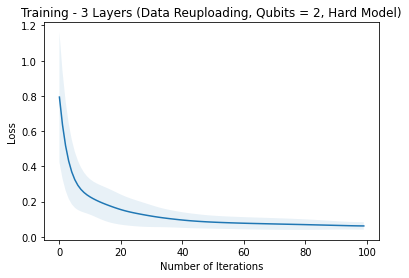

In [10]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 3 Layers (Data Reuploading, Qubits = 2, Hard Model)")

In [15]:
losseasy = np.zeros((100,100))
for i in range(100):
    file = 'Layer3Easy/quantum_loss_easy_layer3h_%d.npy'%i
    losseasy[i] += np.load(file, allow_pickle=True)

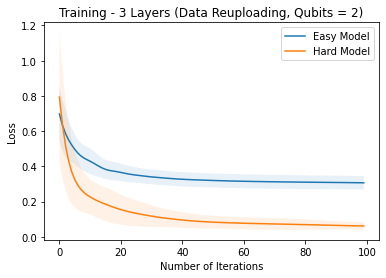

In [16]:
stddevs =[]
averages =[]
sde = np.std(losseasy, axis=0)
ave = np.average(losseasy, axis=0)
plt.plot(range(100), ave)
plt.fill_between(range(100), ave+np.array(sde), ave-np.array(sde), alpha=0.1)
stddevs.append(sde)
averages.append(ave)

plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 3 Layers (Data Reuploading, Qubits = 2)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)